https://stackoverflow.com/questions/51903350/python-vs-matlab-performance-on-algorithm

First we measure the scaling of the serial implementation

_Performance enhancement 1_: use Numba within a single array

In [1]:
!hostname

MS.local


In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

For Numpy, set how floating-point errors are handled.
    
https://docs.scipy.org/doc/numpy/reference/generated/numpy.seterr.html

In [3]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# original code to be profiled optimized
The following is merely a computationally expective function

In [4]:
# https://github.com/nikdon/pyEntropy
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[:sample_length - 1]))
    similarity_ratio = A / B
    se = - np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se

# profile code

In order to optimize effectively, need to understand where hot spots are


## start with function profiling
Conclusion: Most of the time is spent in "sample_entropy"

In [5]:
%prun?

In [6]:
a = np.random.rand(1, 100)[0]

%prun -s tottime sample_entropy(a, 4, 0.1 * np.std(a))

## after determining function hot spot, use line profiling

Once we know that the majority of time is spent in "Sample entropy", investigate which lines are consuming most of the CPU time

https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/

In [8]:
# !pip install line_profiler # we already did this in 1_...

In [9]:
%load_ext line_profiler

In [10]:
a = np.random.rand(1, 100)[0]

%lprun -f sample_entropy sample_entropy(a, 4, 0.1 * np.std(a))

We can see there are some lines that are taking most of the time (primarily the lines inside the loop). 

Therefore, when attempting to optimize the implementation, focus on those lines

## scaling of serial function

Before we try to make the code faster, start by measuring how the code scales as the size of the input increase

In [11]:
num_tests=3 # number of measurements for each array size
serial_original_timing_dict={}
serial_original_reslt_dict={}
for arry_size in [100,1000,2000]:#,5000,10000]:  # vary the array size
    reslt_ary=[]
    for test_indx in range(num_tests): # take multiple measurements for each array size
        a = np.random.rand(1, arry_size)[0] # create array of given size
        start_time = time.time() # start timer
        outp=sample_entropy(a, 4, 0.1 * np.std(a)) # call computationally expensive function
        elapsed_time = time.time() - start_time # how long did that take?
        serial_original_reslt_dict[(arry_size,test_indx)]=outp
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    # store the average of the 3 runs
    serial_original_timing_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 0.007067203521728516 seconds
100 : 0.0065801143646240234 seconds
100 : 0.006600379943847656 seconds
1000 : 0.4781510829925537 seconds
1000 : 0.46221399307250977 seconds
1000 : 0.461456298828125 seconds
2000 : 1.9636569023132324 seconds
2000 : 1.9655771255493164 seconds
2000 : 1.793503999710083 seconds


In [12]:
serial_original_timing_dict

{100: 0.0067492326100667315,
 1000: 0.4672737916310628,
 2000: 1.9075793425242107}

In [13]:
# unpacking operator * -- see https://realpython.com/python-kwargs-and-args/#unpacking-with-the-asterisk-operators
# see https://realpython.com/python-zip-function/
x_orig,y_orig=zip(*serial_original_timing_dict.items())

In [14]:
x_orig # array size

(100, 1000, 2000)

In [15]:
y_orig # time in seconds

(0.0067492326100667315, 0.4672737916310628, 1.9075793425242107)

In [16]:
z_orig = np.polyfit(x_orig, y_orig, 2) # fit data points with second order polynomial -- https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html
z_orig # coefficients of the second order polynomial

array([ 4.88742945e-07, -2.59232856e-05,  4.45413171e-03])

In [17]:
f_orig = np.poly1d(z_orig) # convenience function for polynomials -- https://docs.scipy.org/doc/numpy/reference/generated/numpy.poly1d.html
print('f =\n',f_orig)

f =
            2
4.887e-07 x - 2.592e-05 x + 0.004454


In [18]:
x_orig_filled_in = np.linspace(0, 10000, 50) # https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html
y_orig_filled_in = f_orig(x_orig_filled_in)

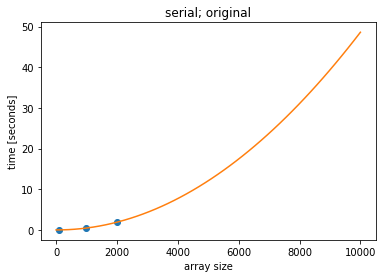

In [19]:
_=plt.plot(x_orig,y_orig,'o', x_orig_filled_in, y_orig_filled_in)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; original')
plt.show()

# _optimization attempt_: replace `for` loop with `list comprehension`
    
According to line profiling, 30% of time is spent in a for loop that could be converted to a lambda function. Let's see what the performance enhancement is due to that change

In [20]:
# https://github.com/nikdon/pyEntropy
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
#        for j in range(nj):                  # original
#            prev[j] = curr[j]
        prev = [curr[j] for j in range(nj)]   # list comprehension

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[:sample_length - 1]))
    similarity_ratio = A / B
    se = - np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se

In [21]:
a = np.random.rand(1, 100)[0]
%lprun -f sample_entropy sample_entropy(a, 4, 0.1 * np.std(a))

In [22]:
num_tests=3
serial_lambda_timing_dict={}
serial_lambda_reslt_dict={}
for arry_size in [100,1000,2000]:#,5000,10000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        outp=sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        serial_lambda_reslt_dict[(arry_size,test_indx)]=outp
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    serial_lambda_timing_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 0.006812334060668945 seconds
100 : 0.006201028823852539 seconds
100 : 0.0062007904052734375 seconds
1000 : 0.4628119468688965 seconds
1000 : 0.4406101703643799 seconds
1000 : 0.46392297744750977 seconds
2000 : 1.8212227821350098 seconds
2000 : 1.7606921195983887 seconds
2000 : 1.7503440380096436 seconds


In [23]:
serial_lambda_timing_dict

{100: 0.006404717763264974, 1000: 0.4557816982269287, 2000: 1.777419646581014}

--> Slightly faster, but not significant

In [24]:
x_lambda,y_lambda=zip(*serial_lambda_timing_dict.items())

In [25]:
z_lambda = np.polyfit(x_lambda, y_lambda, 2)
f_lambda = np.poly1d(z_lambda)
print('f =\n',f_lambda)
x_lambda_filled_in = np.linspace(0, 10000, 50)
y_lambda_filled_in = f_lambda(x_lambda_filled_in)

f =
            2
4.328e-07 x + 2.322e-05 x - 0.0002455


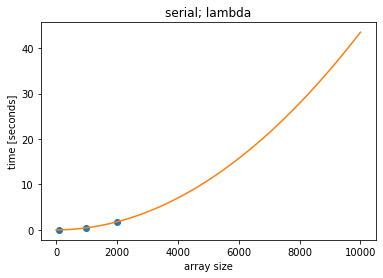

In [26]:
_=plt.plot(x_lambda,y_lambda,'o', x_lambda_filled_in, y_lambda_filled_in)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; lambda')
plt.show()

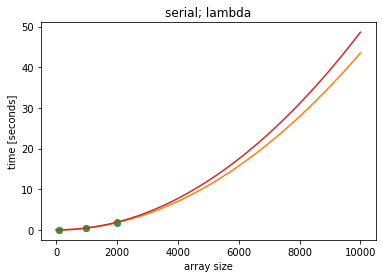

In [27]:
_=plt.plot(x_lambda,y_lambda,'o', x_lambda_filled_in, y_lambda_filled_in)
_=plt.plot(x_orig,y_orig,'o', x_orig_filled_in, y_orig_filled_in)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; lambda')
plt.show()

_Side note; this path is not explored_:<BR>
as far as I understand, in order to use joblib, need to change the for loop to a generator:<BR>
https://joblib.readthedocs.io/en/latest/parallel.html#parallel<BR>
"The core idea is to write the code to be executed as a generator expression, and convert it to parallel computing

## compare output of original and lambda-based

--> I don't know how to interpret the outputs, so I don't know whether the comparisons are acceptable

In [28]:
serial_original_reslt_dict

{(100, 0): array([2.74509147, 2.91617964, 2.83321334,        inf]),
 (100, 1): array([2.88674199, 3.04817875,        inf,        nan]),
 (100, 2): array([2.84766064, 2.86931835, 2.01490302,        inf]),
 (1000, 0): array([2.86591648, 2.87582198, 3.07119068, 2.51230562]),
 (1000, 1): array([2.88340509, 2.90151484, 2.77914612, 2.47443535]),
 (1000, 2): array([2.880582  , 2.93139941, 2.88634761, 2.8094027 ]),
 (2000, 0): array([2.84369631, 2.82411112, 2.88242431, 3.12262403]),
 (2000, 1): array([2.85814334, 2.85056512, 2.84430515, 2.86220088]),
 (2000, 2): array([2.86189077, 2.876322  , 2.93900629, 3.0563569 ])}

In [29]:
serial_lambda_reslt_dict

{(100, 0): array([2.91243148, 2.9216243 ,        inf,        nan]),
 (100, 1): array([2.85465368, 3.06626242, 2.48490665,        inf]),
 (100, 2): array([2.86523578, 3.04452244, 2.56494936,        inf]),
 (1000, 0): array([2.85768656, 2.88035289, 2.87982248, 3.11351531]),
 (1000, 1): array([2.87669988, 2.91634724, 3.02240052,        inf]),
 (1000, 2): array([2.85479593, 2.86487097, 2.85304051, 2.75153531]),
 (2000, 0): array([2.87046026, 2.88086618, 2.8409733 , 2.91506437]),
 (2000, 1): array([2.86473912, 2.86596421, 2.91761628, 2.7668907 ]),
 (2000, 2): array([2.87174983, 2.88597545, 2.83798435, 2.77258872])}

# optimization attempt: fine-grain concurrency: Numba
### Numba = JIT compiler that translates Python and NumPy code into machine code

https://numba.pydata.org/numba-doc/dev/user/performance-tips.html

https://numba.pydata.org/numba-doc/latest/user/parallel.html
https://numba.pydata.org/numba-doc/latest/user/jit.html#parallel-jit-option

In [30]:
import numba as nb

In [31]:
print(nb.__version__)

0.45.1


In [32]:
# https://numba.pydata.org/numba-doc/dev/reference/envvars.html#numba-envvars
import os

# If set to non-zero, printout of Numba warnings is enabled, otherwise the warnings are suppressed. The warnings can give insight into the compilation process.
os.environ["NUMBA_WARNINGS"] = "1"


I recommend playing around with the various arguments to figure out which combination is best

https://realpython.com/primer-on-python-decorators/<BR>
https://www.geeksforgeeks.org/decorators-in-python/

In [33]:
# this is the only modification to the function -- use of a decorator
@nb.jit(fastmath=True,error_model='numpy',parallel=True,nopython=True)
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) // 2

    B2=np.empty(sample_length)
    B2[0]=N
    B2[1:]=B[:sample_length - 1]
    similarity_ratio = A / B2
    se = - np.log(similarity_ratio)
    return se

In [34]:
num_tests=3
numba_reslt_dict={}
for arry_size in [100,1000,5000,10000,50000,100000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    numba_reslt_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 2.3554067611694336 seconds
100 : 0.00043511390686035156 seconds
100 : 0.0001399517059326172 seconds
1000 : 0.0016040802001953125 seconds
1000 : 0.0013370513916015625 seconds
1000 : 0.0011897087097167969 seconds
5000 : 0.026727914810180664 seconds
5000 : 0.025064945220947266 seconds
5000 : 0.02519512176513672 seconds
10000 : 0.10138607025146484 seconds
10000 : 0.10489797592163086 seconds
10000 : 0.11962413787841797 seconds
50000 : 2.788696050643921 seconds
50000 : 2.788231134414673 seconds
50000 : 2.790757179260254 seconds
100000 : 11.260524988174438 seconds
100000 : 11.612228155136108 seconds
100000 : 11.865181922912598 seconds


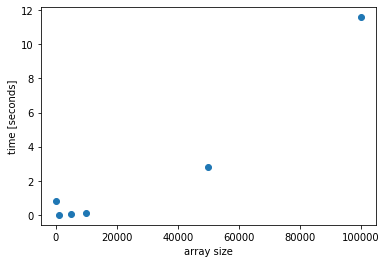

In [35]:
x_numba,y_numba=zip(*numba_reslt_dict.items())
plt.scatter(x_numba,y_numba)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.show()

In [36]:
z_numba = np.polyfit(x_numba, y_numba, 2)

In [37]:
f_numba = np.poly1d(z_numba)
print(f_numba)

           2
1.296e-09 x - 1.634e-05 x + 0.273


In [38]:
x_numba_filled_in = np.linspace(0, 100000, 50)
y_numba_filled_in = f_numba(x_numba_filled_in)

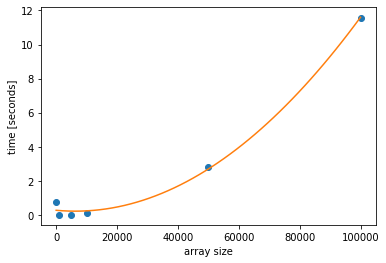

In [39]:
_=plt.plot(x_numba,y_numba,'o', x_numba_filled_in, y_numba_filled_in)
_=plt.ylabel('time [seconds]')
_=plt.xlabel('array size')

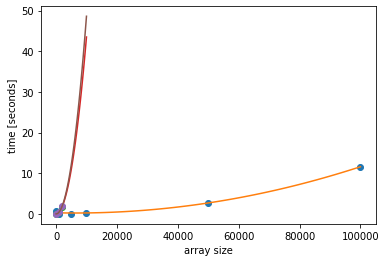

In [40]:
_=plt.plot(x_numba,y_numba,'o', x_numba_filled_in, y_numba_filled_in)
_=plt.plot(x_lambda,y_lambda,'o', x_lambda_filled_in, y_lambda_filled_in)
_=plt.plot(x_orig,y_orig,'o', x_orig_filled_in, y_orig_filled_in)
_=plt.ylabel('time [seconds]')
_=plt.xlabel('array size')

In [41]:
x=18000000 # array size
print((2.092e-09*x*x) - (5.401e-06*x) + 0.01703,'seconds')

677710.7990299999 seconds


677710.7990299999 seconds = 8 days

In [42]:
x=30000 # array size
print((2.092e-09*x*x) - (5.401e-06*x) + 0.01703,'seconds')

1.7377999999999998 seconds
